# 1. Cài đặt thư viện cần thiết

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

import numpy as np

# 2. Kiểm tra GPU


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


#3. Cài đặt drive lưu kết quả và tải dataset



In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
WORKING_DIR = '/content/drive/MyDrive/lab2-adip'

In [43]:
import os

if not os.path.exists(WORKING_DIR):
    os.makedirs(WORKING_DIR)

%cd $WORKING_DIR

/content/drive/MyDrive/lab2-adip


## 4. Tải và lưu dataset MNIST



In [44]:
# Đường dẫn lưu dataset trên Google Drive
location_path = '/content/drive/MyDrive/' + 'lab2-adip/dataset'

# Định nghĩa transform trước khi truyền vào dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Batch size mới
batch_size = 128

# Tải dataset MNIST
dataset = torchvision.datasets.MNIST(root=location_path, train=True, download=True, transform=transform)

# Tạo DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 5. Định nghĩa mô hình Discriminator


#Tự code

In [45]:
class Discriminator(nn.Module):
    def __init__(self, inp_dim=784):
        super(Discriminator, self).__init__()
        self.w1 = nn.Parameter(torch.randn(inp_dim, 128) * 0.02)  # Dùng nn.Parameter
        self.b1 = nn.Parameter(torch.zeros(128))
        self.w2 = nn.Parameter(torch.randn(128, 1) * 0.02)
        self.b2 = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        x = x.view(x.size(0), 784)
        h = torch.matmul(x, self.w1) + self.b1
        h = torch.maximum(0.2 * h, h)  # LeakyReLU
        out = torch.matmul(h, self.w2) + self.b2
        out = torch.sigmoid(out)  # Sigmoid
        return out


#Tham khảo lab

In [57]:
class Discriminator(nn.Module):
    def __init__(self, inp_dim=784):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(inp_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.view(x.size(0), 784)  # Flatten (batch_size x 1 x 28 x 28) -> (batch_size x 784)
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.sigmoid(out)
        return out


# 6. Định nghĩa mô hình Generator


#Tự code

In [46]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.w1 = nn.Parameter(torch.randn(z_dim, 128) * 0.02)
        self.b1 = nn.Parameter(torch.zeros(128))
        self.w2 = nn.Parameter(torch.randn(128, 784) * 0.02)
        self.b2 = nn.Parameter(torch.zeros(784))

    def forward(self, x):
        h = torch.matmul(x, self.w1) + self.b1
        h = torch.maximum(0.2 * h, h)  # LeakyReLU
        out = torch.matmul(h, self.w2) + self.b2
        out = torch.tanh(out)  # [-1, 1]
        out = out.view(out.size(0), 1, 28, 28)
        return out


#Tham khảo lab

In [58]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 784)

    def forward(self, x):
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.tanh(out)  # Đưa giá trị về khoảng [-1, 1]
        out = out.view(out.size(0), 1, 28, 28)  # Chuyển về kích thước ảnh
        return out

# 7. Khởi tạo mô hình


In [59]:


# Re-initialize D, G (Assuming Discriminator and Generator classes are defined)
D = Discriminator().to(device)
G = Generator().to(device)



# 8. Hàm mất mát và bộ tối ưu hóa


In [60]:


print("Discriminator parameters:", sum(p.numel() for p in D.parameters() if p.requires_grad))
print("Generator parameters:", sum(p.numel() for p in G.parameters() if p.requires_grad))

# Set up the optimizers for Discriminator and Generator
# Adam is better than SGD for this task
#optimizerD = torch.optim.SGD(D.parameters(), lr=0.03)
#optimizerG = torch.optim.SGD(G.parameters(), lr=0.03)

# Uncomment to use Adam optimizer instead
optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002)
optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002)

# Define the loss function BCE (Binary Cross-Entropy)
criterion = nn.BCELoss()
batch_size = 128




Discriminator parameters: 100609
Generator parameters: 114064


# 9. Huấn luyện mô hình


#Nhập giá trị noise vector

In [61]:
noise_dim = int(input("Nhập giá trị noise_dim: "))
print(f"Noise dimension: {noise_dim}")


Nhập giá trị noise_dim: 100
Noise dimension: 100


Epoch [1/50] - Loss D: 0.6258, Loss G: 1.0880
Epoch [2/50] - Loss D: 0.8162, Loss G: 0.8870
Epoch [3/50] - Loss D: 0.7715, Loss G: 1.1367
Epoch [4/50] - Loss D: 0.9076, Loss G: 1.1635
Epoch [5/50] - Loss D: 0.6617, Loss G: 1.4175
Epoch [6/50] - Loss D: 1.1555, Loss G: 0.9519
Epoch [7/50] - Loss D: 1.0158, Loss G: 1.1037
Epoch [8/50] - Loss D: 1.0228, Loss G: 1.0853
Epoch [9/50] - Loss D: 0.9585, Loss G: 1.1802
Epoch [10/50] - Loss D: 1.0343, Loss G: 1.0802
Epoch [11/50] - Loss D: 1.1292, Loss G: 0.9880
Epoch [12/50] - Loss D: 1.2004, Loss G: 0.9373
Epoch [13/50] - Loss D: 1.2116, Loss G: 0.9709
Epoch [14/50] - Loss D: 1.1835, Loss G: 1.0442
Epoch [15/50] - Loss D: 1.0052, Loss G: 1.1540
Epoch [16/50] - Loss D: 1.0829, Loss G: 1.0324
Epoch [17/50] - Loss D: 1.2994, Loss G: 0.8645
Epoch [18/50] - Loss D: 1.2031, Loss G: 0.9578
Epoch [19/50] - Loss D: 1.1928, Loss G: 0.9581
Epoch [20/50] - Loss D: 1.1399, Loss G: 0.9923
Epoch [21/50] - Loss D: 1.1594, Loss G: 0.9712
Epoch [22/50] - Loss D

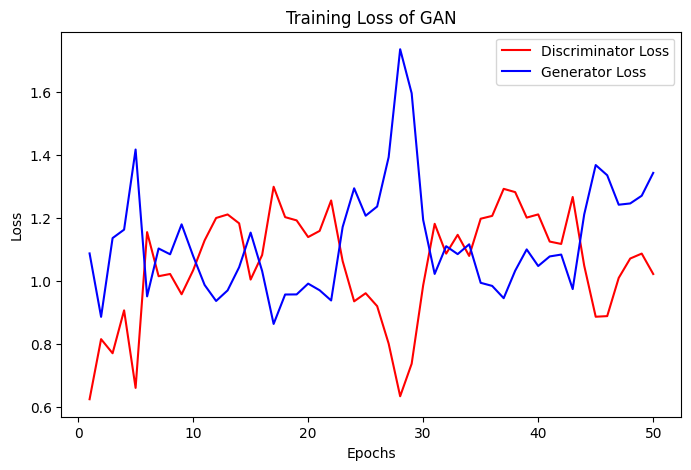

In [62]:
import torch
import matplotlib.pyplot as plt

# Số epochs
epochs = 50

# Danh sách lưu loss
lossD_list = []
lossG_list = []

for epoch in range(epochs):
    lossD_epoch = 0
    lossG_epoch = 0
    num_batches = 0

    for i, data in enumerate(dataloader):
        x_real, _ = data
        x_real = x_real.to(device)

        # Labels cho dữ liệu thật và giả
        lab_real = torch.ones((x_real.size(0), 1), device=device)
        lab_fake = torch.zeros((x_real.size(0), 1), device=device)

        # ---- Training Discriminator ----
        optimizerD.zero_grad()
        lossD_real = criterion(D(x_real), lab_real)

        z = torch.randn(x_real.size(0), noise_dim, device=device)
        x_gen = G(z).detach()
        lossD_fake = criterion(D(x_gen), lab_fake)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # ---- Training Generator ----
        optimizerG.zero_grad()
        z = torch.randn(x_real.size(0), noise_dim, device=device)
        x_gen = G(z)
        lossG = criterion(D(x_gen), lab_real)  # Generator muốn đánh lừa D

        lossG.backward()
        optimizerG.step()

        # Tính tổng loss trong epoch
        lossD_epoch += lossD.item()
        lossG_epoch += lossG.item()
        num_batches += 1

    # Lưu loss trung bình vào danh sách
    lossD_list.append(lossD_epoch / num_batches)
    lossG_list.append(lossG_epoch / num_batches)

    print(f"Epoch [{epoch+1}/{epochs}] - Loss D: {lossD_list[-1]:.4f}, Loss G: {lossG_list[-1]:.4f}")

# ---- Vẽ đồ thị ----
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), lossD_list, label="Discriminator Loss", color="red")
plt.plot(range(1, epochs+1), lossG_list, label="Generator Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss of GAN")
plt.legend()
plt.show()


#10. Sinh ảnh và hiển thị


Ảnh đã lưu tại: /content/drive/My Drive/lab2-adip/generated_image.png


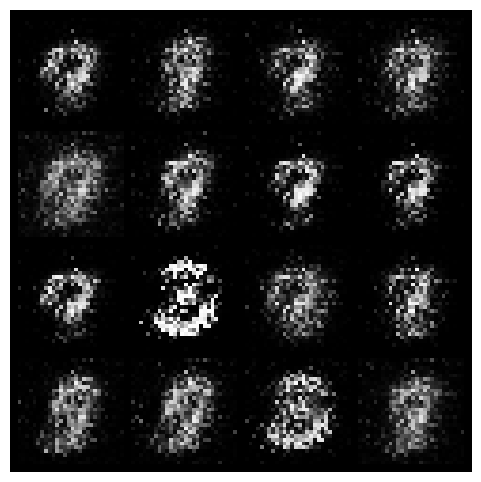

In [64]:
from PIL import Image

def show_generated_images(G, num_images=16, noise_dim=100, device="cpu", save_path=None):
    G.eval()  # Đặt Generator ở chế độ đánh giá
    with torch.no_grad():
        z = torch.randn(num_images, noise_dim, device=device)
        fake_images = G(z).detach().cpu()

    grid = make_grid(fake_images, normalize=True, nrow=4)
    np_img = np.transpose(grid.numpy(), (1, 2, 0))  # Chuyển về định dạng ảnh

    plt.figure(figsize=(6, 6))
    plt.imshow(np_img)
    plt.axis("off")

    if save_path:
        image = Image.fromarray((np_img * 255).astype(np.uint8))  # Convert to image
        image.save(save_path)
        print(f"Ảnh đã lưu tại: {save_path}")

    plt.show()
    G.train()  # Đặt lại Generator về chế độ training

# Gọi hàm và lưu ảnh vào Google Drive
save_path = "/content/drive/My Drive/lab2-adip/generated_image.png"  # Thay đổi đường dẫn nếu cần
show_generated_images(G, device=device, save_path=save_path)
